<a href="https://colab.research.google.com/github/Rakshit-Sawarn-iitb/WIDS-Brain-Tumor-Detection/blob/main/BrainTumorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import gc
import os
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir = "/content/drive/MyDrive/brain_tumor_dataset"
paths = []
labels = []

for label in ['yes', 'no']:
  for dirname, _, filenames in os.walk(os.path.join(dir,label)):
        for filename in filenames:
            paths.append(os.path.join(dirname, filename))
            labels.append(1 if label is 'yes' else 0)

len(paths), len(labels)

<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-3-99b34089f5dd>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  labels.append(1 if label is 'yes' else 0)


(263, 263)

In [4]:
sizes = []
for path in paths:
    im = Image.open(path)
    sizes.append(im.size)
    im.close()

print(max(sizes), min(sizes))

(1920, 1080) (150, 198)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(paths, labels, stratify=labels, test_size=0.2, shuffle=True, random_state=1357)
print(len(X_train), len(X_test))

210 53


In [6]:
class MRIDataset():
    def __init__(self, paths, labels, augmentations=None):
      self.paths = paths
      self.labels = labels

      if augmentations is None:
          self.augmentations = transforms.Compose([transforms.ToTensor()])
      else:
          self.augmentations = augmentations

    def __len__(self):
      return len(self.paths)

    def __getitem__(self, index):
      label = self.labels[index]

      sample = Image.open(self.paths[index]).convert(mode="RGB")
      sample = self.augmentations(sample)

      return (sample,torch.tensor(label, dtype=torch.float))

In [7]:
train_augmentations = transforms.Compose([transforms.Resize((240,240)), transforms.ToTensor()])
test_augmentations = transforms.Compose([transforms.Resize((240,240)), transforms.ToTensor()])

In [8]:
train_dataset = MRIDataset(X_train, y_train, augmentations=train_augmentations)
test_dataset = MRIDataset(X_test, y_test, augmentations=test_augmentations)

tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0039],
         [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0039],
         [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0039],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0039],
         [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0039],
         [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0039],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0039],
         [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0039],
         [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.

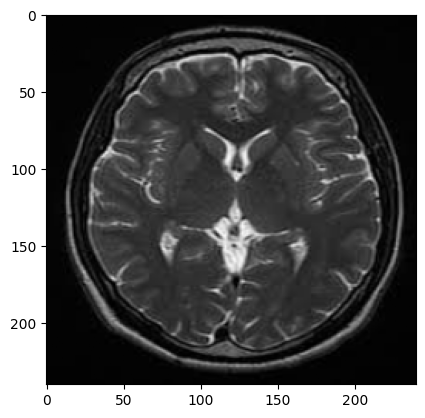

In [9]:
random_sample, random_label = test_dataset[0]
print(random_sample)
plt.imshow(random_sample.permute(1, 2, 0))
print(random_label.item())

In [10]:
class Config:
  learning_rate = 1e-3
  epochs = 10
  train_batch_size = 8
  test_batch_size = 8

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = Config.train_batch_size,
                                               shuffle = True,
                                               num_workers = 2
                                              )

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size = Config.test_batch_size,
                                              shuffle = True,
                                              num_workers = 2
                                              )

len(train_dataloader), len(test_dataloader)

(27, 7)

In [12]:
class Model(nn.Module):

    def __init__(self, in_features=3):
      super(Model, self).__init__()


      self.conv_block = nn.Sequential(nn.Conv2d(in_channels=in_features,
                                               out_channels=32,
                                               kernel_size=3,
                                               stride=1
                                               ),
                                     nn.MaxPool2d(4,4),
                                     nn.MaxPool2d(2,2),
                                     nn.MaxPool2d(2,2)
                                    )
      with torch.no_grad():
          dummy_input = torch.randn(1, in_features, 240, 240)
          dummy_output = self.conv_block(dummy_input)
          flattened_size = dummy_output.view(dummy_output.size(0), -1).size(1)

      self.linear_block = nn.Sequential(
                                        nn.Linear(flattened_size,256),
                                        nn.Linear(256,1)
                                       )


    def forward(self,x):
      x = self.conv_block(x)
      x = torch.flatten(x,1)
      x = self.linear_block(x)
      return x

In [13]:
model = Model()
print(model)

Model(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=6272, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [15]:
class Trainer:

    def __init__(self, model, dataloaders, Config):
      self.model = model
      self.train, self.test = dataloaders

      self.Config = Config

      self.optim = torch.optim.Adam(self.model.parameters(), lr=self.Config.learning_rate)
      self.loss_fn = nn.BCEWithLogitsLoss()


    def binary_accuracy(self, outputs, labels):
      return (torch.round(torch.sigmoid(outputs)) == labels).sum().item() / labels.shape[0]


    def train_one_epoch(self):

      running_loss = 0
      running_acc = 0

      for X,y in self.train:

        X = X.to(device, dtype = torch.float)
        y = y.reshape(y.shape[0],1)
        y = y.to(device, dtype = torch.float)

        self.optim.zero_grad()

        outputs = self.model(X)
        loss = self.loss_fn(outputs, y)

        loss.backward()
        self.optim.step()

        running_loss += loss.item()
        running_acc += self.binary_accuracy(outputs, y)

        del X
        del y
        gc.collect()
        torch.cuda.empty_cache()

      train_loss = running_loss / len(self.train)
      train_acc = running_acc / len(self.train)

      return train_loss, train_acc


    def fit(self):

      losses = []
      accuracies = []

      for epoch in range(self.Config.epochs):

        self.model.train()

        train_loss, train_acc = self.train_one_epoch()
        losses.append(train_loss)
        accuracies.append(train_acc)
        print(f"EPOCH {epoch+1}/{self.Config.epochs}")
        print(f"Training Loss: {train_loss} | Training Accuracy: {train_acc}\n\n")


    @torch.no_grad()
    def inference(self):

      self.model.eval()

      running_acc = 0

      for X,y in self.test:

        X = X.to(device, torch.float)
        y = y.reshape(y.shape[0],1)
        y = y.to(device, dtype = torch.float)
        outputs = self.model(X)
        running_acc += self.binary_accuracy(outputs, y)

        del X
        del y
        gc.collect()
        torch.cuda.empty_cache()
      accuracy = (running_acc / len(self.test))
      accuracy = accuracy*100
      return accuracy

    def predict(self, input_image):
      self.model.eval()

      input_image = input_image.to(device, torch.float)
      output = self.model(input_image)

        # Assuming your output is a single scalar value, you might want to use sigmoid
      prediction = torch.sigmoid(output).item()

      return prediction

In [16]:
trainer = Trainer(model, (train_dataloader, test_dataloader), Config)
trainer.fit()

EPOCH 1/10
Training Loss: 0.7688926375574536 | Training Accuracy: 0.7083333333333334


EPOCH 2/10
Training Loss: 0.44071389458797594 | Training Accuracy: 0.8148148148148148


EPOCH 3/10
Training Loss: 0.3730111938935739 | Training Accuracy: 0.8425925925925926


EPOCH 4/10
Training Loss: 0.3250263496129601 | Training Accuracy: 0.8703703703703703


EPOCH 5/10
Training Loss: 0.23990493488532524 | Training Accuracy: 0.8981481481481481


EPOCH 6/10
Training Loss: 0.269729714150782 | Training Accuracy: 0.8981481481481481


EPOCH 7/10
Training Loss: 0.24157078869433868 | Training Accuracy: 0.8842592592592593


EPOCH 8/10
Training Loss: 0.13909895386960772 | Training Accuracy: 0.9537037037037037


EPOCH 9/10
Training Loss: 0.08751766521621633 | Training Accuracy: 0.9722222222222222


EPOCH 10/10
Training Loss: 0.04728083159015686 | Training Accuracy: 1.0




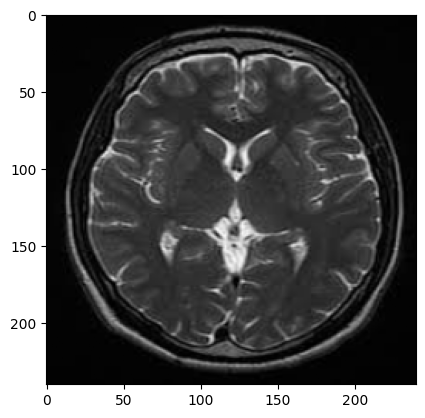

Actual:0.0
Model Prediction: Less or No Tumor Detected


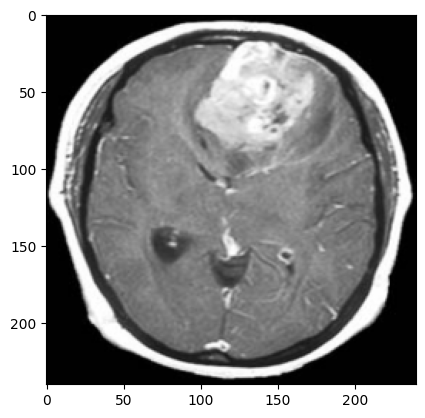

Actual:1.0
Model Prediction: Tumor Detected


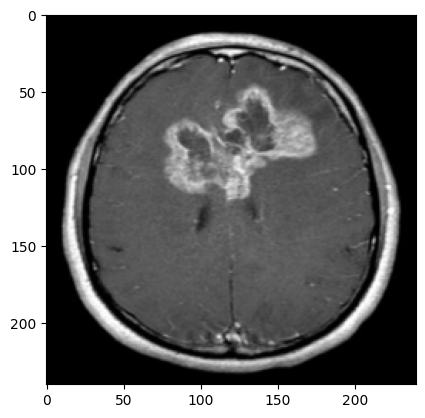

Actual:1.0
Model Prediction: Tumor Detected


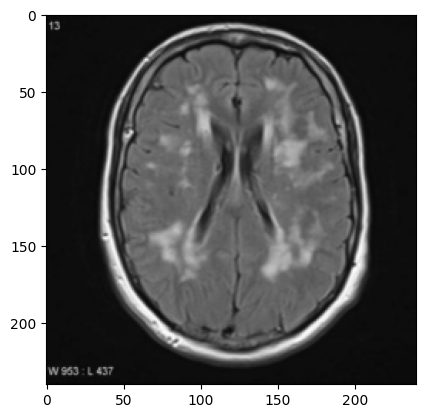

Actual:0.0
Model Prediction: Tumor Detected


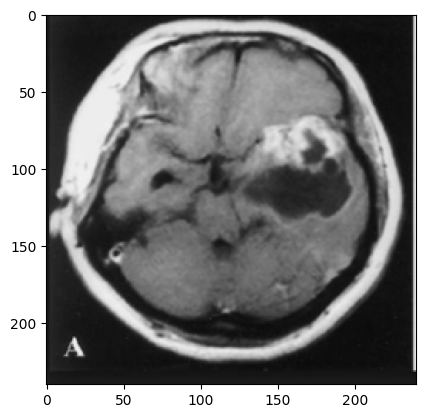

Actual:1.0
Model Prediction: Tumor Detected


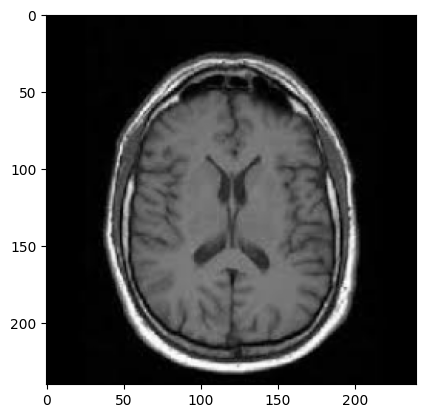

Actual:0.0
Model Prediction: Less or No Tumor Detected


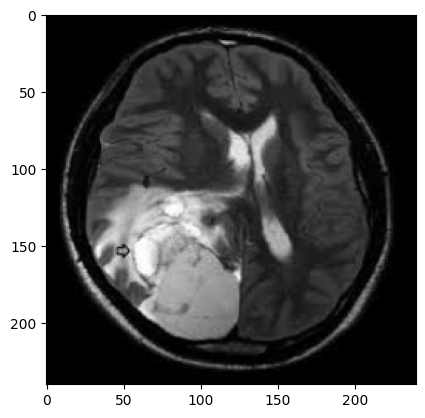

Actual:1.0
Model Prediction: Tumor Detected


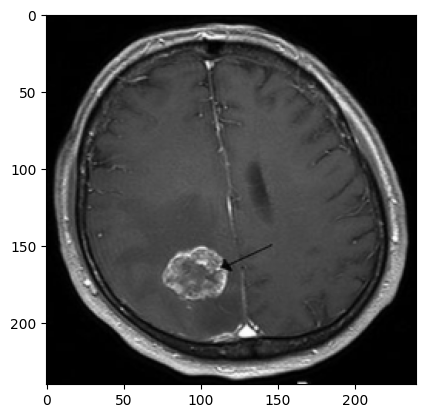

Actual:1.0
Model Prediction: Tumor Detected


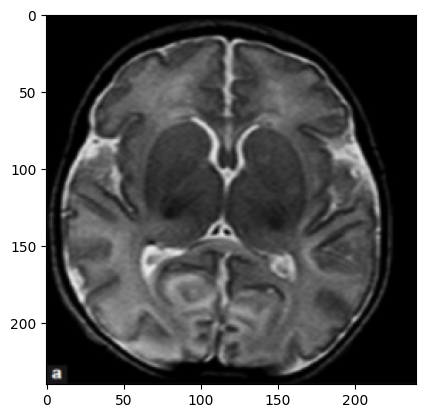

Actual:0.0
Model Prediction: Less or No Tumor Detected


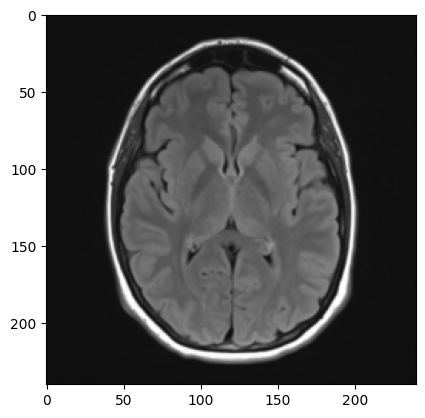

Actual:0.0
Model Prediction: Less or No Tumor Detected


In [17]:
for i in range(10):
  random_sample, random_label = test_dataset[i]
  random = random_sample.unsqueeze(0)
  #plt.imshow(random_sample.permute(1, 2, 0))
  plt.imshow(random.permute(0, 2, 3, 1)[0])
  plt.show()
  print(f"Actual:{random_label}")

  prediction = trainer.predict(random)
  if (prediction<0.5):
    print("Model Prediction: Less or No Tumor Detected")
  else:
    print("Model Prediction: Tumor Detected")

In [27]:
def test_acc(test_data):
  actual = []
  pred = []
  acc = 0
  for i in range(len(test_data)):
    random_sample, random_label = test_dataset[i]
    random = random_sample.unsqueeze(0)

    actual.append(random_label)

    prediction = trainer.predict(random)
    if (prediction<0.5):
      pred.append(0)
    else:
      pred.append(1)

  for i in range(len(pred)):
    if (actual[i]==pred[i]):
      acc+=1

  return (acc/len(pred))*100

In [29]:
acc = test_acc(test_dataset)
print(f"Accuracy on test data : {acc}")

Accuracy on test data : 86.79245283018868
